# Predicting Destinations with the Airbnb Dataset

This notebook demonstrates the entire process of building a predictive model to suggest the first destination of new Airbnb Users. data wrangling, exploratory data analysis, inferential statistics and machine learning techniques are involved.




In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

### Age, Gender and Population Statistics

In [2]:
df_agb = pd.read_csv('age_gender_bkts.csv')
df_agb.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [3]:
#Check for all features by replacing the key of the mask.
df_agb[df_agb['year'].isnull()]

,age_bucket,country_destination,gender,population_in_thousands,year


In [4]:
#Convert 100+ into a bin.
df_agb['age_bucket'] = df_agb['age_bucket'].apply(lambda x: '100-104' if x == '100+' else x)
#Define mean_age feature
df_agb['mean_age'] = df_agb['age_bucket'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1]))/2)
df_agb = df_agb.drop('age_bucket', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,year,mean_age
0,AU,male,1.0,2015.0,102.0
1,AU,male,9.0,2015.0,97.0
2,AU,male,47.0,2015.0,92.0
3,AU,male,118.0,2015.0,87.0
4,AU,male,199.0,2015.0,82.0


In [5]:
df_agb['country_destination'].value_counts()

US    42
NL    42
AU    42
ES    42
IT    42
DE    42
PT    42
GB    42
CA    42
FR    42
Name: country_destination, dtype: int64

In [6]:
df_agb['gender'].value_counts()

female    210
male      210
Name: gender, dtype: int64

In [7]:
df_agb['gender'] = df_agb['gender'].apply(lambda x: 0 if x == 'male' else 1)
df_agb['gender'].value_counts()

1    210
0    210
Name: gender, dtype: int64

In [8]:
df_agb['year'].value_counts()

2015.0    420
Name: year, dtype: int64

In [9]:
df_agb = df_agb.drop('year', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,mean_age
0,AU,0,1.0,102.0
1,AU,0,9.0,97.0
2,AU,0,47.0,92.0
3,AU,0,118.0,87.0
4,AU,0,199.0,82.0


### Country Statistics

In [10]:
df_con = pd.read_csv('countries.csv')
df_con

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


### Sessions 

In [11]:
df_ses = pd.read_csv('sessions.csv')
df_ses.head(15)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [12]:
df_ses.shape

(10567737, 6)

In [13]:
df_ses['action'] = df_ses['action'].replace('-unknown-', np.nan)
df_ses['action_type'] = df_ses['action_type'].replace('-unknown-', np.nan)
df_ses['action_detail'] = df_ses['action_detail'].replace('-unknown-', np.nan)

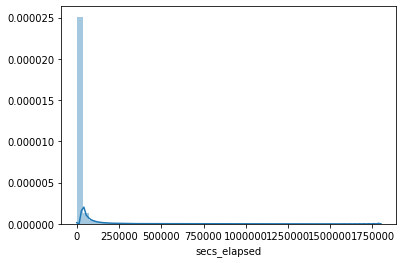

In [14]:
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])

In [15]:
df_ses['secs_elapsed'].describe()

count    1.043171e+07
mean     1.940581e+04
std      8.888424e+04
min      0.000000e+00
25%      2.290000e+02
50%      1.147000e+03
75%      8.444000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

In [16]:
len(df_ses[df_ses['secs_elapsed'].isnull()])

136031

In [17]:
median_secs = df_ses['secs_elapsed'].median()
df_ses['secs_elapsed'] = df_ses['secs_elapsed'].fillna(median_secs)

In [18]:
df_ses['secs_elapsed'].describe()

count    1.056774e+07
mean     1.917078e+04
std      8.833430e+04
min      0.000000e+00
25%      2.370000e+02
50%      1.147000e+03
75%      8.193000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

In [19]:
null_action = df_ses[(df_ses['action_type'].isnull()) | (df_ses['action_detail'].isnull()) | (df_ses['action'].isnull()) ]
null_action.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [20]:
null_action.shape

(2237000, 6)

In [21]:
len(null_action['action'].drop_duplicates())

270

In [22]:
df_ses[df_ses['device_type'].isnull()]

,user_id,action,action_type,action_detail,device_type,secs_elapsed


In [23]:
df_ses['device_type'] = df_ses['device_type'].replace('-unknown-', np.nan)

In [24]:
df_ses['device_type'].value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [25]:
len(df_ses[df_ses['device_type'].isnull()])

211279

### Training Users

Let us now explore the training dataset which consists of our users for whom we need to predict the first destination. 

In [27]:
df_train = pd.read_csv('train_users_2.csv')
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [28]:
df_train.shape

(213451, 16)

In [29]:
df_train['gender'] = df_train['gender'].replace('-unknown-', np.nan)
df_train['first_browser'] = df_train['first_browser'].replace('-unknown-', np.nan)

In [30]:
df_train[df_train['first_device_type'].isnull()]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination


In [31]:
df_train[df_train['age'] > 120].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,NaN,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [32]:
df_train['age'] = df_train['age'].apply(lambda x: np.nan if x > 120 else x)

## Inferential Statistics

### Gender Preference for Airbnb Bookings

In [33]:
df_inf = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other') & (df_train['gender'] != 'OTHER') & (df_train['gender'].notnull())]
df_inf = df_inf[['id', 'gender', 'country_destination']]
df_inf.head()

,id,gender,country_destination
2,4ft3gnwmtx,FEMALE,US
6,lsw9q7uk0j,FEMALE,US
7,0d01nltbrs,FEMALE,US
8,a1vcnhxeij,FEMALE,US
10,yuuqmid2rp,FEMALE,US


In [34]:
df_inf['gender'].value_counts()

FEMALE    28833
MALE      24278
Name: gender, dtype: int64

In [35]:
df_inf['country_destination'].value_counts()

US    42151
FR     3297
IT     1790
GB     1563
ES     1530
CA      932
DE      774
NL      532
AU      395
PT      147
Name: country_destination, dtype: int64

In [36]:
observed = df_inf.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
del observed.columns.name
observed = observed.set_index('gender')
observed

,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
FEMALE,207,455,358,853,1962,881,1091,254,78,22694
MALE,188,477,416,677,1335,682,699,278,69,19457


In [37]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [38]:
chi2

116.87183139602567

In [39]:
p

5.830126955071572e-21

In [40]:
df_signup = df_train[(df_train['signup_method'] != 'google')][['id', 'signup_method', 'signup_app']]
df_signup['device'] = df_signup['signup_app'].apply(lambda x: 'Computer' if x == 'Web' else 'Mobile')
df_signup.head()

,id,signup_method,signup_app,device
0,gxn3p5htnn,facebook,Web,Computer
1,820tgsjxq7,facebook,Web,Computer
2,4ft3gnwmtx,basic,Web,Computer
3,bjjt8pjhuk,facebook,Web,Computer
4,87mebub9p4,basic,Web,Computer


In [41]:
df_signup['signup_method'].value_counts()

basic       152897
facebook     60008
Name: signup_method, dtype: int64

In [42]:
df_signup['device'].value_counts()

Computer    182717
Mobile       30188
Name: device, dtype: int64

In [43]:
df_signup = df_signup.pivot_table('id', ['device'], 'signup_method', aggfunc='count')
df_signup.index = ['Computer', 'Mobile']
df_signup.columns = ['Basic', 'Facebook']
df_signup

,Basic,Facebook
Computer,131237,51480
Mobile,21660,8528


#### Chi Square Test

In [44]:
chi2, p, dof, expected = stats.chi2_contingency(df_signup, correction=False)

In [45]:
chi2

0.07183824273421707

In [46]:
p

0.7886788661023779

In [47]:
df_signup.loc['Total'] = [ df_signup['Basic'].sum(), df_signup['Facebook'].sum()]
df_signup['Total'] = df_signup['Basic'] + df_signup['Facebook']
df_signup

,Basic,Facebook,Total
Computer,131237,51480,182717
Mobile,21660,8528,30188
Total,152897,60008,212905


In [48]:
fb_prop = df_signup.loc['Mobile', 'Facebook']/df_signup.loc['Total', 'Facebook']
fb_std = df_signup.loc['Mobile', 'Facebook'] * ((1 - fb_prop) ** 2) + df_signup.loc['Computer', 'Facebook'] * ((0 - fb_prop) ** 2)
fb_std = np.sqrt(fb_std/df_signup.loc['Total', 'Facebook'])

fb_prop, fb_std

(0.14211438474870017, 0.3491674188640724)

In [49]:
basic_prop = df_signup.loc['Mobile', 'Basic']/df_signup.loc['Total', 'Basic']
basic_std = df_signup.loc['Mobile', 'Basic'] * ((1 - basic_prop) ** 2) + df_signup.loc['Computer', 'Basic'] * ((0 - basic_prop) ** 2)
basic_std = np.sqrt(basic_std/df_signup.loc['Total', 'Basic'])

basic_prop, basic_std

(0.14166399602346677, 0.34870518816635054)

In [50]:
h0_prop = 0

prop_diff = fb_prop - basic_prop
p_hat = (df_signup.loc['Mobile', 'Basic'] + df_signup.loc['Mobile', 'Facebook'])/(df_signup.loc['Total', 'Basic'] + df_signup.loc['Total', 'Facebook']) 
var_diff = p_hat * (1- p_hat) * (1/df_signup.loc['Total', 'Basic'] + 1/df_signup.loc['Total', 'Facebook'])
sigma_diff = np.sqrt(var_diff)

prop_diff, sigma_diff

(0.0004503887252333971, 0.001680388342245922)

In [51]:
z = (prop_diff - h0_prop) / sigma_diff
z

0.2680265709481359

In [52]:
p = (1-stats.norm.cdf(z))*2
p

0.7886788661023794

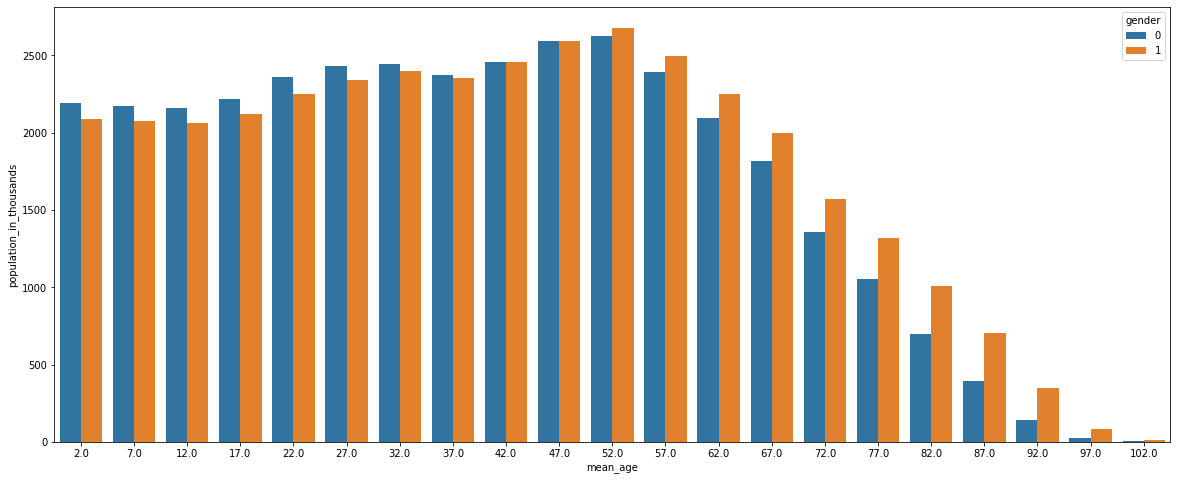

In [53]:
plt.figure(figsize=(20,8))
sns.barplot(x='mean_age', y='population_in_thousands', hue='gender', data=df_agb, ci=None)

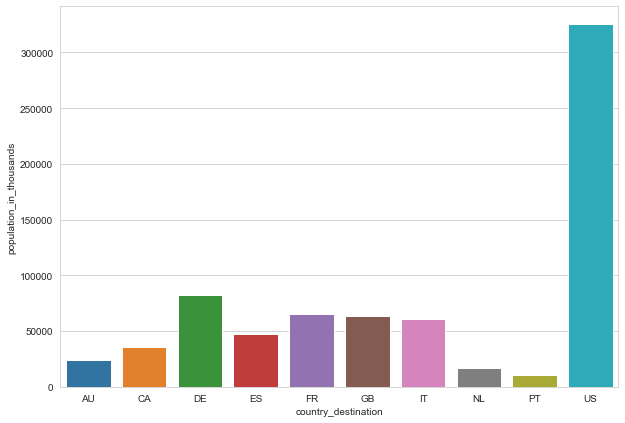

In [54]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
pop_stats = df_agb.groupby('country_destination')['population_in_thousands'].sum()
sns.barplot(x=pop_stats.index, y=pop_stats)

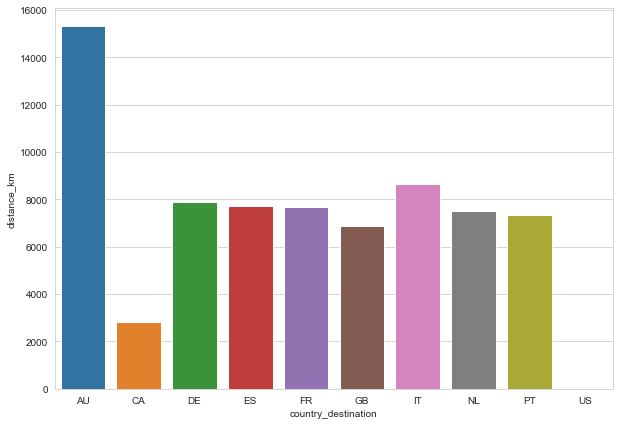

In [55]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='country_destination', y='distance_km', data=df_con)

In [56]:
country_popularity = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other')]['country_destination'].value_counts()

In [57]:
country_distance = pd.Series(df_con['distance_km'])
country_distance.index = df_con['country_destination']

In [58]:
language_distance = pd.Series(df_con['language_levenshtein_distance'])
language_distance.index = df_con['country_destination']

In [59]:
country_area = pd.Series(df_con['destination_km2'])
country_area.index = df_con['country_destination']

/Users/wanzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


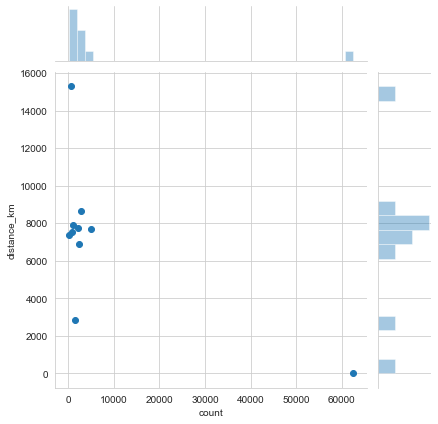

In [60]:
df_dp = pd.concat([country_popularity, country_distance, language_distance, country_area], axis=1)
df_dp.columns = ['count', 'distance_km', 'language', 'area']
sns.jointplot(x='count', y='distance_km', data=df_dp)

There is a **strong negative correlation of -0.65.** People overwhelmingly prefer booking in the United States than any other country in the world. We can attribute this preference to distance. Let us check if this holds true for just the interantional countries as well.

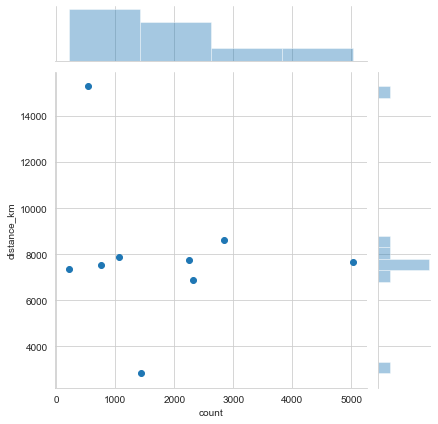

In [61]:
sns.jointplot(x='count', y='distance_km', data=df_dp.drop('US'))

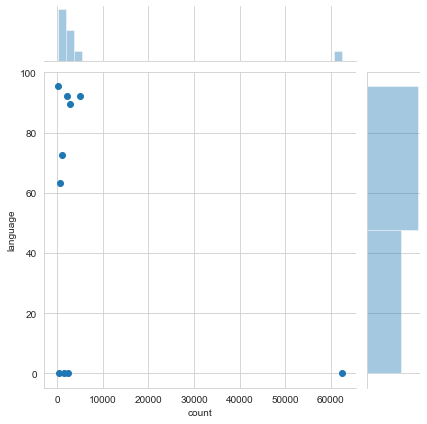

In [62]:
sns.jointplot(x='count', y='language', data=df_dp)

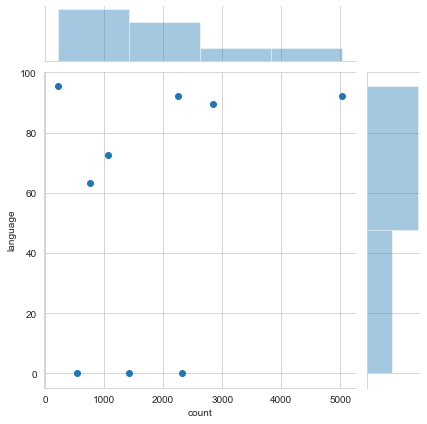

In [63]:
sns.jointplot(x='count', y='language', data=df_dp.drop('US'))

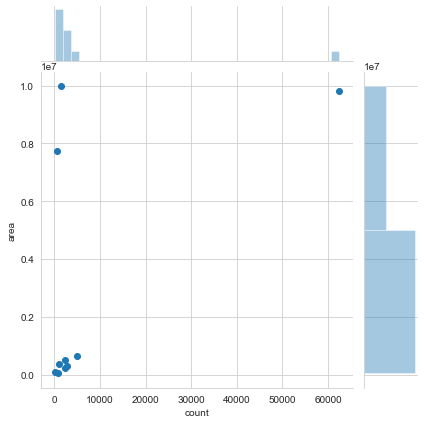

In [64]:
sns.jointplot(x='count', y='area', data=df_dp)

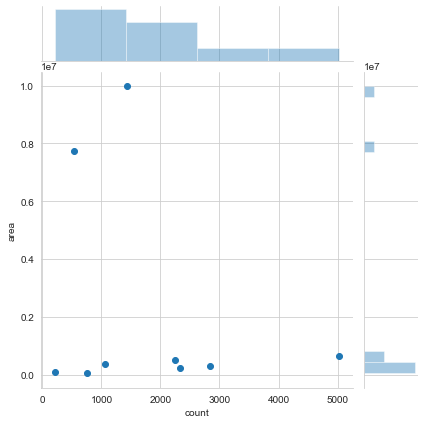

In [65]:
sns.jointplot(x='count', y='area', data=df_dp.drop('US'))

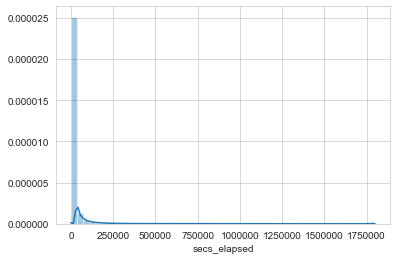

In [66]:
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])

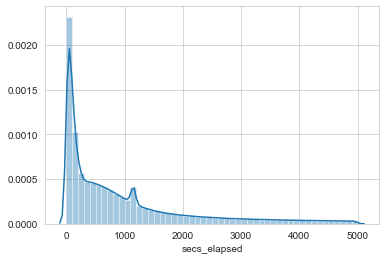

In [67]:
sns.distplot(df_ses[(df_ses['secs_elapsed'].notnull()) & (df_ses['secs_elapsed'] < 5000)]['secs_elapsed'])

In [68]:
len(df_ses[df_ses['secs_elapsed'] < 1000])/len(df_ses[df_ses['secs_elapsed'].notnull()])

0.4672638049186879

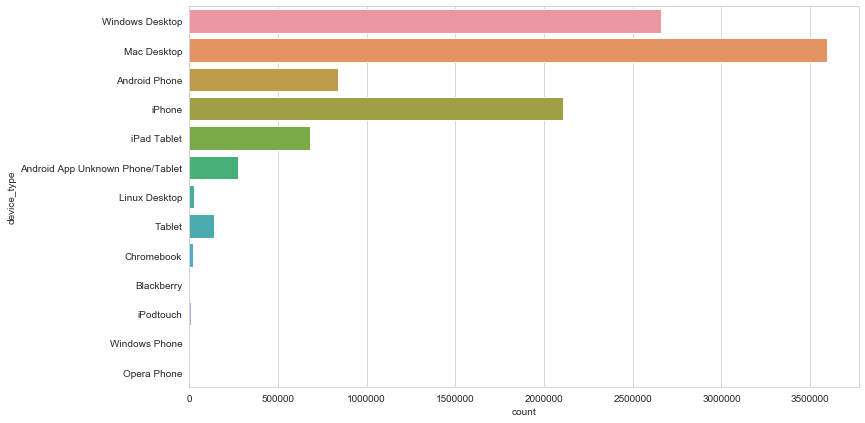

In [69]:
plt.figure(figsize=(12,7))
sns.countplot(y='device_type', data=df_ses)

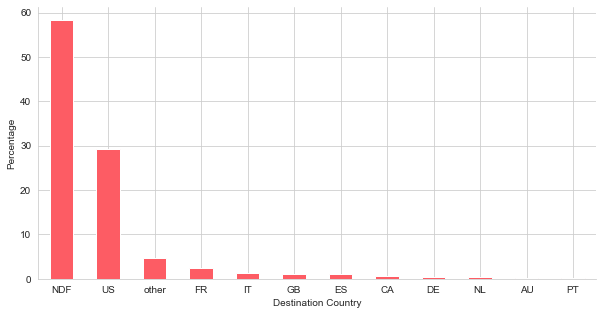

In [70]:
plt.figure(figsize=(10,5))
country_share = df_train['country_destination'].value_counts() / df_train.shape[0] * 100
country_share.plot(kind='bar',color='#FD5C64', rot=0)
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

In [71]:
classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']

In [72]:
def stacked_bar(feature):
    ctab = pd.crosstab([df_train[feature].fillna('Unknown')], df_train.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(kind='bar', stacked=True, colormap='terrain', legend=False)

#### Gender

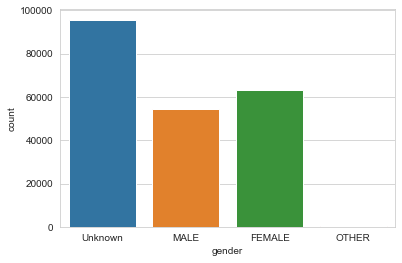

In [73]:
sns.countplot(df_train['gender'].fillna('Unknown'))

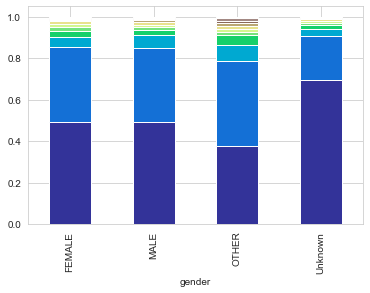

In [74]:
stacked_bar('gender')

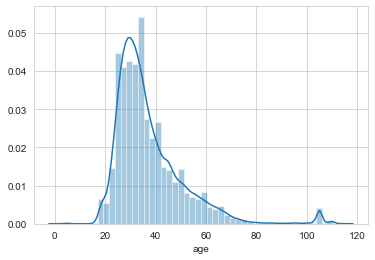

In [75]:
sns.distplot(df_train['age'].dropna())

(10, 75)

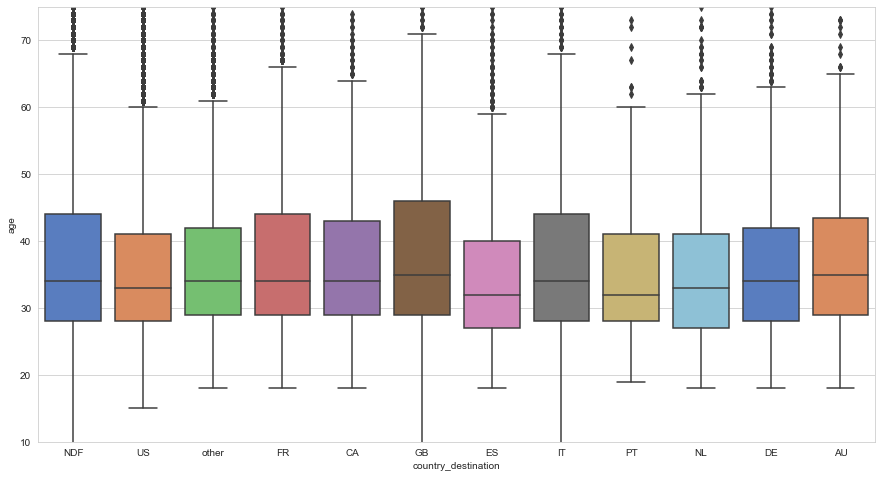

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='country_destination', y='age', data=df_train, palette="muted", ax =ax)
ax.set_ylim([10, 75])

In [77]:
def set_age_group(x):
    if x < 40:
        return 'Young'
    elif x >=40 and x < 60:
        return 'Middle'
    elif x >= 60 and x <= 125:
        return 'Old'
    else:
        return 'Unknown'

In [78]:
df_train['age_group'] = df_train['age'].apply(set_age_group)

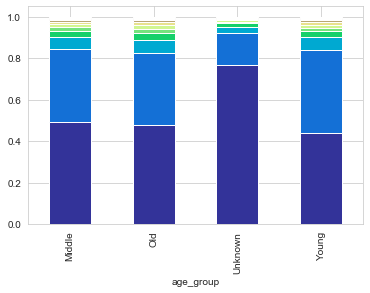

In [79]:
stacked_bar('age_group')

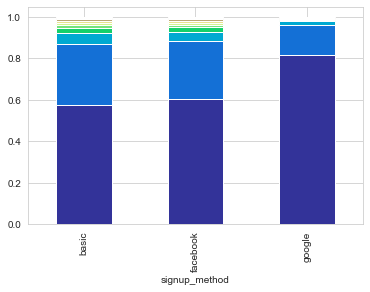

In [80]:
stacked_bar('signup_method')

#### Language

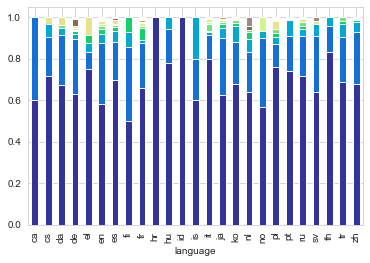

In [81]:
stacked_bar('language')

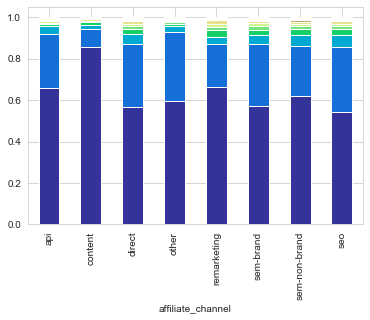

In [82]:
stacked_bar('affiliate_channel')

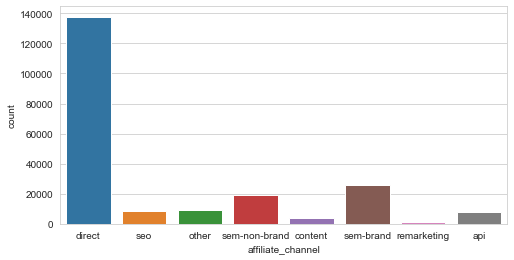

In [83]:
plt.figure(figsize=(8,4))
sns.countplot(df_train['affiliate_channel'])

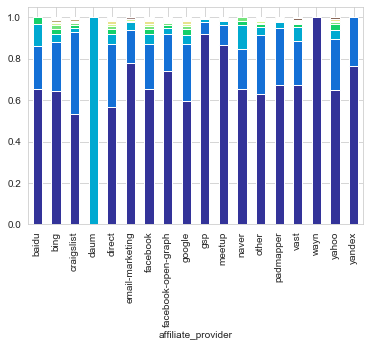

In [84]:
stacked_bar('affiliate_provider')

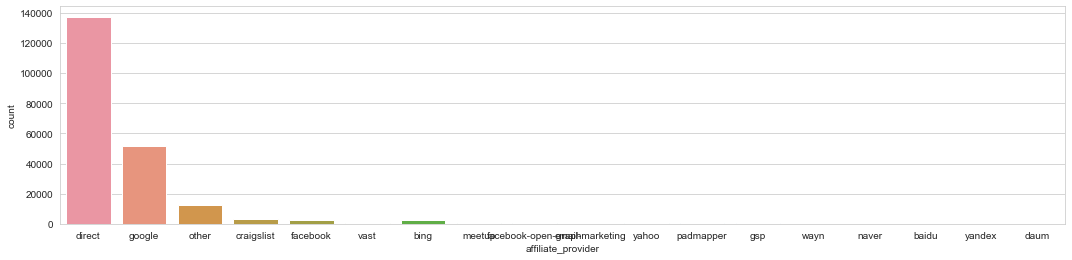

In [85]:
plt.figure(figsize=(18,4))
sns.countplot(df_train['affiliate_provider'])

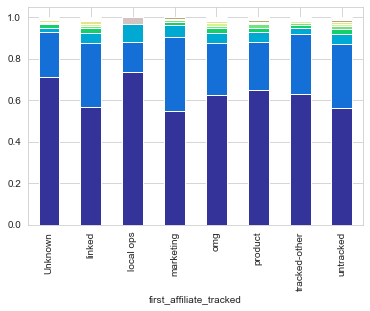

In [86]:
stacked_bar('first_affiliate_tracked')

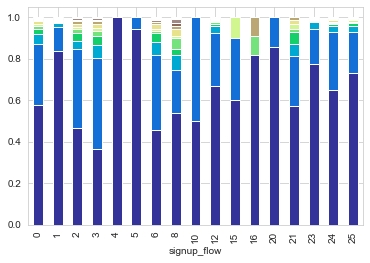

In [87]:
stacked_bar('signup_flow')



#### Type of Device, Browser and App Used

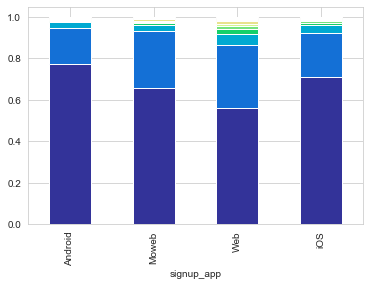

In [88]:
stacked_bar('signup_app')

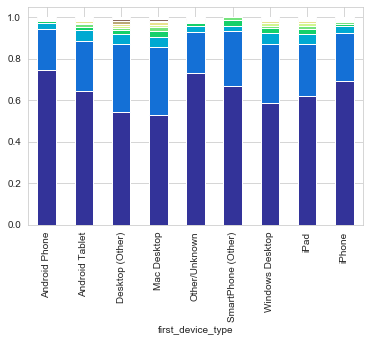

In [89]:
stacked_bar('first_device_type')

In [90]:
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])

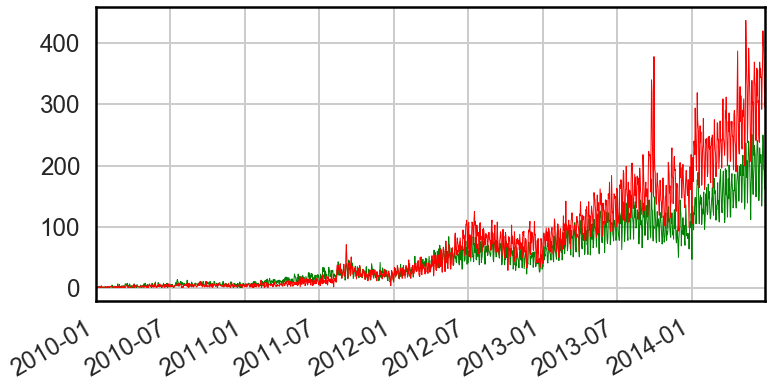

In [91]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
plt.figure(figsize=(12,6))

df_train[df_train['country_destination'] != 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='green')
df_train[df_train['country_destination'] == 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='red')

In [92]:


df_ses.head(2)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0


In [93]:
def session_features(df):
    df['total_seconds'] = df['id'].apply(lambda x: total_seconds[x] if x in total_seconds else 0)
    df['average_seconds'] = df['id'].apply(lambda x: average_seconds[x] if x in average_seconds else 0)
    df['total_sessions'] = df['id'].apply(lambda x: total_sessions[x] if x in total_sessions else 0)
    df['distinct_sessions'] = df['id'].apply(lambda x: distinct_sessions[x] if x in distinct_sessions else 0)
    df['num_short_sessions'] = df['id'].apply(lambda x: num_short_sessions[x] if x in num_short_sessions else 0)
    df['num_long_sessions'] = df['id'].apply(lambda x: num_long_sessions[x] if x in num_long_sessions else 0)
    df['num_devices'] = df['id'].apply(lambda x: num_devices[x] if x in num_devices else 0)
    return df

In [94]:
def browsers(df):
    df['first_browser'] = df['first_browser'].apply(lambda x: "Mobile_Safari" if x == "Mobile Safari" else x)
    major_browsers = ['Chrome', 'Safari', 'Firefox', 'IE', 'Mobile_Safari']
    df['first_browser'] = df['first_browser'].apply(lambda x: 'Other' if x not in major_browsers else x)
    return df

In [95]:
def classify_device(x):
    if x.find('Desktop') != -1:
        return 'Desktop'
    elif x.find('Tablet') != -1 or x.find('iPad') != -1:
        return 'Tablet'
    elif x.find('Phone') != -1:
        return 'Phone'
    else:
        return 'Unknown'

In [96]:
def devices(df):
    df['first_device_type'] = df['first_device_type'].apply(classify_device)
    return df

In [97]:
def affiliate_tracked(df):
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].fillna('Unknown')
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].apply(lambda x: 'Other' if x != 'Unknown' and x != 'untracked' else x)
    return df

In [98]:
def affiliate_provider(df):
    df['affiliate_provider'] = df['affiliate_provider'].apply(lambda x: 'rest' if x not in ['direct', 'google', 'other'] else x)
    return df

In [99]:
def affiliate_channel(df):
    df['affiliate_channel'] = df['affiliate_channel'].apply(lambda x: 'other' if x  not in ['direct', 'content'] else x)
    return df

In [100]:
def languages(df):
    df['language'] = df['language'].apply(lambda x: 'foreign' if x != 'en' else x)
    return df

In [101]:
def first_booking(df):
    df = df.drop('date_first_booking', axis=1)
    return df

In [102]:
def account_created(df):
    df = df.drop('date_account_created', axis=1)
    return df

In [103]:
def feature_engineering(df):
    df = session_features(df)
    df = df.drop('age', axis=1)
    df = browsers(df)
    df =devices(df)
    df =affiliate_tracked(df)
    df = affiliate_provider(df)
    df = affiliate_channel(df)
    df = languages(df)
    df['is_3'] = df['signup_flow'].apply(lambda x: 1 if x==3 else 0)
    df = first_booking(df)
    df = df.drop('timestamp_first_active', axis=1)
    df = account_created(df)
    df = df.set_index('id')
    df = pd.get_dummies(df, prefix='is')
    return df

In [104]:
total_seconds = df_ses.groupby('user_id')['secs_elapsed'].sum()

In [105]:
average_seconds = df_ses.groupby('user_id')['secs_elapsed'].mean()

In [106]:
total_sessions = df_ses.groupby('user_id')['action'].count()

In [107]:
distinct_sessions = df_ses.groupby('user_id')['action'].nunique()

In [108]:
num_short_sessions = df_ses[df_ses['secs_elapsed'] <= 300].groupby('user_id')['action'].count()
num_long_sessions = df_ses[df_ses['secs_elapsed'] >= 2000].groupby('user_id')['action'].count()

In [109]:
num_devices = df_ses.groupby('user_id')['device_type'].nunique()

In [110]:
df_train = session_features(df_train)

Since we already have our age groups, we can drop the age feature.

In [111]:
df_train = df_train.drop('age', axis=1)

There are more than 50 categories of browsers although the majority use only 5. Therefore, we will club all the minor browsers into the 'Other' category.

Next, from our visualisation above, we saw that desktop users were most likely to book Airbnbs, followed by Tablet users, Phone users and finally people whose devices were unknown. Let us reduce first_device_type into these categories.

In [112]:
df_train = browsers(df_train)

In [113]:
df_train = devices(df_train)

Let us do the same with the affiliates.

In [114]:
df_train = affiliate_tracked(df_train)

In [115]:
df_train = affiliate_provider(df_train)

In [116]:
df_train = affiliate_channel(df_train)

In [117]:
df_train = languages(df_train)

In [118]:
df_train['is_3'] = df_train['signup_flow'].apply(lambda x: 1 if x==3 else 0)
df_train['gender'] = df_train['gender'].fillna('Unknown')

In [119]:
df_train = first_booking(df_train)

In [120]:



df_train = df_train.drop('timestamp_first_active', axis=1)

In [121]:
df_train = account_created(df_train)

In [122]:




df_train = df_train.set_index('id')

In [123]:
class_dict = {
    'NDF': 0,
    'US': 1,
    'other': 2,
    'FR': 3,
    'CA': 4,
    'GB': 5,
    'ES': 6,
    'IT': 7,
    'PT': 8,
    'NL': 9,
    'DE': 10,
    'AU': 11
}

In [124]:

X, y = df_train.drop('country_destination', axis=1), df_train['country_destination'].apply(lambda x: class_dict[x])

In [125]:
X = pd.get_dummies(X, prefix='is')

In [126]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, stratify=y)

In [127]:
classifiers = [RandomForestClassifier(verbose=1), LogisticRegression(verbose=1), GradientBoostingClassifier(verbose=True)]

for classifier in classifiers:
    classifier.fit(train_X, train_y)
    print("Score: " + str(classifier.score(test_X, test_y)))

/Users/wanzin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
/Users/wanzin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wanzin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWa

Score: 0.6184809699604595
[LibLinear]

/Users/wanzin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score: 0.583194348143845
      Iter       Train Loss   Remaining Time 
         1      182365.5378           10.40m
         2      179613.3170           10.05m
         3      177595.7528           10.45m
         4      176149.1490           10.01m
         5      175012.6990            9.68m
         6      174114.8273            9.37m
         7      173456.5889            9.11m
         8      172931.5183            8.93m
         9      172504.1844            8.73m
        10      172142.5820            8.59m
        20      169834.0407            8.30m
        30      168619.4512            7.08m
        40      167742.9646            5.70m
        50      167077.4001            4.64m
        60      166413.2777            3.56m
        70      165937.5981            2.67m
        80      165427.8302            1.77m
        90      164936.3718           53.17s
       100      164490.3673            0.00s
Score: 0.6339785994040815


### Hyperparameter Tuning using Grid Search Cross Validation

In [128]:
parameters = {
    'n_estimators': [100,200],
    'max_features': ['auto', 'log2'],
    'max_depth': [3,5]
}

In [ ]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, verbose=100)
clf.fit(train_X, train_y)

/Users/wanzin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV]  max_depth=3, max_features=auto, n_estimators=100, score=0.633, total= 6.2min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................


In [ ]:
clf.best_params_

In [ ]:

#classifier = GradientBoostingClassifier()
#classifier.fit(train_X, train_y)
#classifier.score(test_X, test_y)

In [ ]:
df_test = pd.read_csv('data/test_users.csv')
df_test['gender'] = df_test['gender'].replace('-unknown-', 'Unknown')
df_test['age_group'] = df_test['age'].apply(set_age_group)
df_test.head()

In [ ]:
df_test = feature_engineering(df_test)
df_test = df_test.drop('is_weibo', axis=1)

In [ ]:
df_test.columns

In [ ]:
X.columns

In [ ]:
pred_prob = classifier.predict_proba(df_test)

In [ ]:
pred_prob = pd.DataFrame(pred_prob, index=df_test.index)
pred_prob.head()

In [ ]:
inv_classes = {v: k for k, v in class_dict.items()}
inv_classes

In [ ]:
def get_top(s):
    indexes = [i for i in range(0,12)]
    lst = list(zip(indexes, s))
    top_five = sorted(lst, key=lambda x: x[1], reverse=True)[:5]
    top_five = [inv_classes[i[0]] for i in top_five]
    return str(top_five)

In [ ]:
pred_prob['get_top'] = pred_prob.apply(get_top, axis=1)
pred_prob.head()

In [ ]:
import ast
pred_prob['get_top'] = pred_prob['get_top'].apply(lambda x: ast.literal_eval(x))

In [ ]:
s = pred_prob.apply(lambda x: pd.Series(x['get_top']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'country'

In [ ]:
submission = pred_prob.drop([i for i in range(0,12)] + ['get_top'], axis=1).join(s)
submission.head()

In [ ]:
submission.to_csv('submission.csv')